In [1]:
%matplotlib inline

# Test of Reaction Scaling

This is the test system that is described in VODE.  We boost the reaction rates by an amount `boost`.  Bot the RHS and Jacobian are scaled.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import ode

In [3]:
def rhs(t, Y, boost):
    """ RHS of the system -- using 0-based indexing """
    y1 = Y[0]
    y2 = Y[1]
    y3 = Y[2]

    dy1dt = -0.04*y1 + 1.e4*y2*y3
    dy2dt =  0.04*y1 - 1.e4*y2*y3 - 3.e7*y2**2
    dy3dt =                         3.e7*y2**2

    return np.array([boost*dy1dt, boost*dy2dt, boost*dy3dt])

In [4]:
def jac(t, Y, boost):
    """ J_{i,j} = df_i/dy_j """

    y1 = Y[0]
    y2 = Y[1]
    y3 = Y[2]
    
    df1dy1 = -0.04
    df1dy2 = 1.e4*y3
    df1dy3 = 1.e4*y2

    df2dy1 = 0.04
    df2dy2 = -1.e4*y3 - 6.e7*y2
    df2dy3 = -1.e4*y2

    df3dy1 = 0.0
    df3dy2 = 6.e7*y2
    df3dy3 = 0.0

    return np.array([ [ boost*df1dy1, boost*df1dy2, boost*df1dy3 ],
                      [ boost*df2dy1, boost*df2dy2, boost*df2dy3 ],
                      [ boost*df3dy1, boost*df3dy2, boost*df3dy3 ] ])

In [5]:
def VODEIntegrate(Y0, dt, tmax, boost=1.0):
    """ integrate using the VODE method, start with a timestep of dt and
        increase by 10x after each call until we reach tmax.  This is 
        the behavior used in the DVODE Fortran source. """

    r = ode(rhs, jac).set_integrator("vode", method="bdf", 
                                     with_jacobian=True,
                                     atol=1.e-10, rtol=1.e-7,
                                     nsteps = 15000, order=5) #, min_step=dt)


    t = 0.0
    r.set_initial_value(Y0, t)
    r.set_f_params(boost)
    r.set_jac_params(boost)
    
    tout = [t]
    y1out = [Y0[0]]
    y2out = [Y0[1]]
    y3out = [Y0[2]]

    while r.successful() and r.t < tmax:
        r.integrate(r.t+dt)

        tout.append(r.t)
        y1out.append(r.y[0])
        y2out.append(r.y[1])
        y3out.append(r.y[2])

        dt = 10.0*dt

    # access the VODE iwork array to get information about the number of steps
    print("number of steps taken = {}".format(r._integrator.iwork[11]))

    return np.array(tout), \
        np.array(y1out), np.array(y2out), np.array(y3out)

In [6]:
def integrate_and_plot(boost):
    Y0 = np.array([1.0, 0.0, 0.0])
    tmax = 4.e7

    # first call -- give an initial small timestep and have our integrate
    # routine increase it by 10x each call to VODE to get to tmax
    dt_init = 4.e-6

    t, y1, y2, y3 = VODEIntegrate(Y0, dt_init, tmax, boost=boost)


    # second call -- give an initial timestep of tmax -- VODE will handle
    # everything
    t_single, y1_single, y2_single, y3_single = VODEIntegrate(Y0, tmax, tmax, boost=boost)

    ax = plt.gca()
    ax.set_xscale('log')
    ax.set_yscale('log')

    plt.plot(t, y1, label=r"$y_1$")
    plt.scatter(t_single, y1_single,
                label="r$y_1$ from single VODE call")

    plt.plot(t, y2, label=r"$y_2$")
    plt.scatter(t_single, y2_single,
                label="r$y_2$ from single VODE call")

    plt.plot(t, y3, label=r"$y_3$")
    plt.scatter(t_single, y3_single,
                label="r$y_3$ from single VODE call")

    plt.legend(loc=8, frameon=False, fontsize="small")

    f = plt.gcf()
    f.set_size_inches(10,8)
    plt.xlim(1.e-6, 1.e8)
    plt.ylim(1.e-12, 10.0)
    plt.grid()
    plt.xlabel("$t$")
    plt.ylabel(r"$Y(t)$")
    plt.title("VODE reference stiff nonlinear system")

number of steps taken = 1301
number of steps taken = 1441


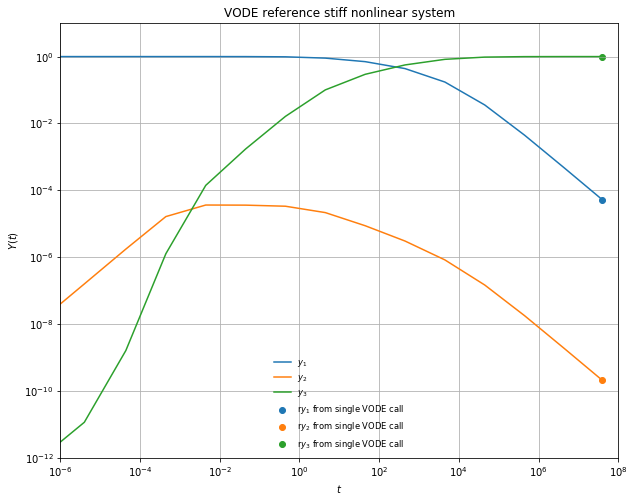

In [7]:
integrate_and_plot(1.0)

number of steps taken = 1397
number of steps taken = 1310


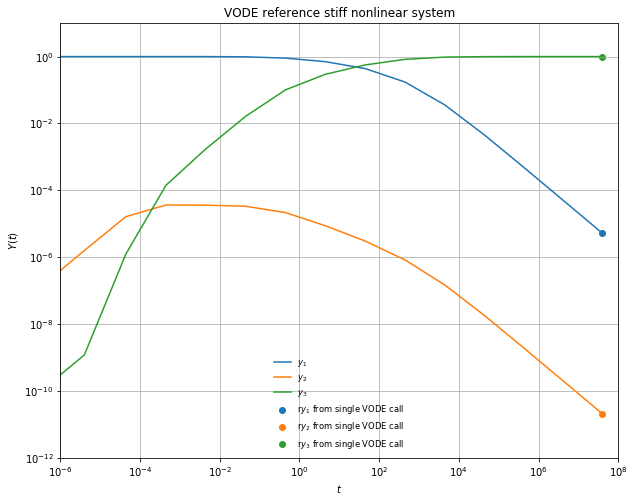

In [8]:
integrate_and_plot(10)